In [1]:
#Loads modules
import torch as t
import matplotlib.pyplot as plt

import os

import sys
dir_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(dir_path,'scripts'))

import json

import importlib
import Systems as Systems
import Plotting as Plotting
import Training as Training
import Controls as Controls
import Evolvers as Evolvers

In [449]:
experiment = "Flensmon2D_1"

In [484]:
#Loads the params_dict for the experiment
exp_path = os.path.join(dir_path,"Experiments",experiment)

params_filepath = os.path.join(exp_path,"Parameters.json")
with open(params_filepath) as json_file:
    params_dict = json.load(json_file)

params_dict.update({"exp_path":exp_path})

I added a factor half to the cosines
Loaded UE0s


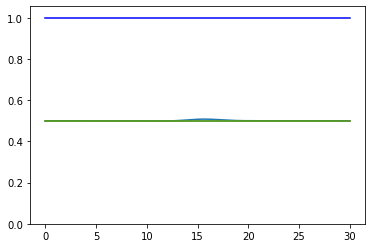

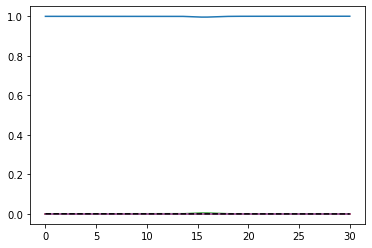

In [485]:
importlib.reload(Systems)
importlib.reload(Plotting)
importlib.reload(Training)
importlib.reload(Controls)
importlib.reload(Evolvers)

class Flensmon_1D(t.nn.Module, Systems.Periodic_System, Controls.CauchyPulse, Evolvers.ETrotter, Training.Trainer, Plotting.Plotter):
    def __init__(self,params_dict):
        super().__init__()
        self.params_dict = params_dict
        super(t.nn.Module,self).__init__()
        return
    
    def forward(self):
        H = self.get_H(self.activation_func(self.times),self.get_control())
        self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
        # self.latest_matrix_exp = self.basis_change@t.matrix_exp(-1j*H*self.dt)
        return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))

    def V_1d(self, alphas, control):
        return self.EJ*(-2*self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            + alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)
    
    def V_2d(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            - alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)

obj = Flensmon_1D(params_dict)
# obj.plot_potential()
obj.plot_activation_func()
obj.plot_occupancy(indices=[_ for _ in range(5)])

In [389]:
# plt.figure(figsize=(15,15))
# plt.plot(obj.times,(obj.H0_term.T.diagonal().real-obj.H0_term.T.diagonal().real[:,[0]])/obj.EJ);

In [528]:
obj.minimize(0.1,200)

initial loss: 0.1571429967880249
Ended at step: 808, with loss: 0.14214247465133667 and runtime: 226.38575196266174


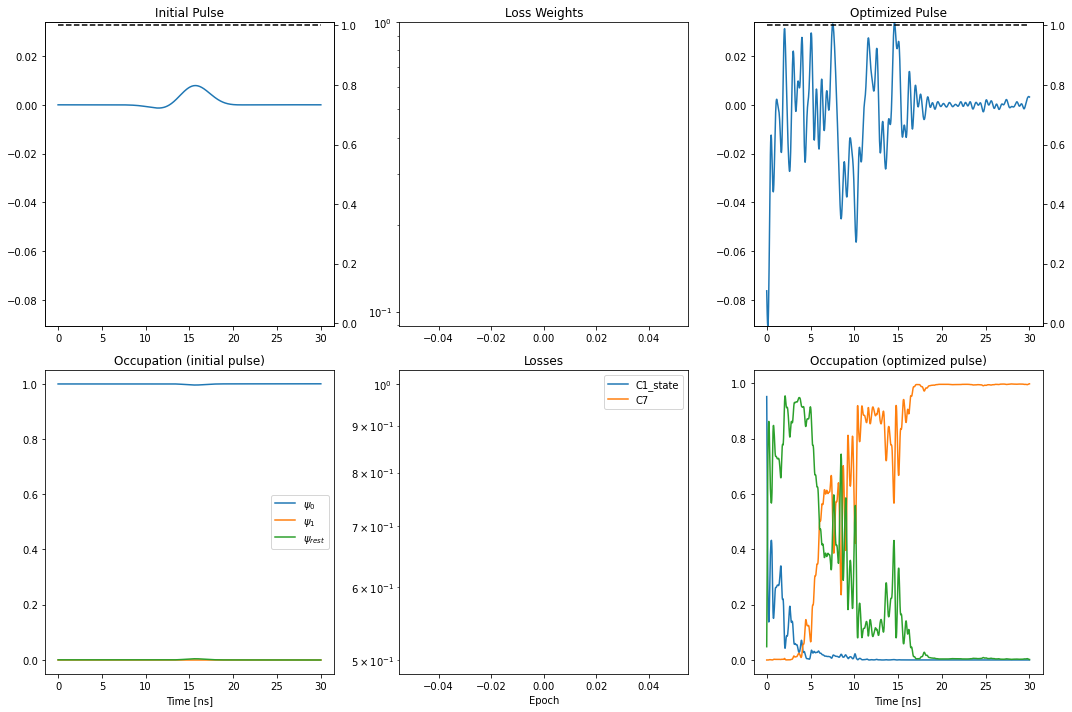

In [533]:
# obj.plot_run(save=False,fig_name="ConstantAlpha_NoWeights_0toPulse.pdf")

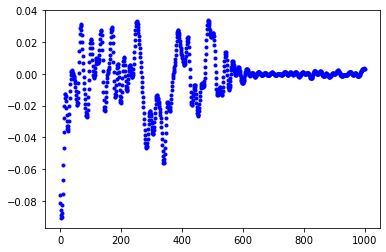

In [532]:
plt.plot(pulse,'b.')

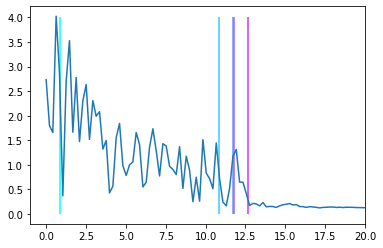

In [530]:
pulse = obj.get_control().detach().clone()
eigvals = obj.H0_term[0].real.diagonal()
energies = [eigvals[3]-eigvals[2],
            eigvals[2]-eigvals[1],
            eigvals[3]-eigvals[1],
            eigvals[2]-eigvals[0],
            eigvals[3]-eigvals[0]]


fft = t.fft.rfft(pulse)
fig, ax = plt.subplots()
ax.plot(t.linspace(0,t.pi/obj.dt,obj.NTrot//2+1),fft.abs())
ax.set_xlim(-1,20)
for i,E in enumerate(energies):
    ax.vlines(E,0,4,colors=(i/len(energies),1-i/len(energies),1))

In [431]:
thetas = t.linspace(0,2*t.pi,100).cfloat()
def z(t1,t2):
    return t.exp(1j*0.5*(t1-t2)) + 1/9*t.exp(1j*3/2*(t1-t2)) + 1/3*(t.exp(1j*(3/2*t1 - 0.5*t2)) + t.exp(1j*(t1/2-3/2*t2)))

diff = t.zeros(100,100).cfloat()
for i,t1 in enumerate(thetas):
    for j,t2 in enumerate(thetas):
        diff[i,j] = z(t1,t2)

tensor(0.2902+1.2968j)

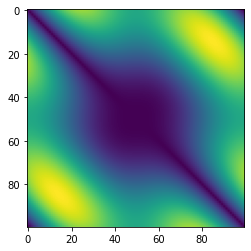

In [438]:
plt.imshow(diff.imag.abs())
diff[80,20]